## Demo with DECam data

This walkthrough uses the Burke et al. 2019 dataset, but superceeds the old Matterport Mask R-CNN implementation.

#### A few notes:

The data can be obtained following the links in the [old repository](https://github.com/burke86/astro_rcnn). The dataset directories should be re-named "test", "train", and "val".

In [1]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger

setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random

# from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data import build_detection_train_loader
from detectron2.engine import DefaultTrainer
from detectron2.engine import SimpleTrainer
from detectron2.engine import HookBase
from detectron2.structures import BoxMode
import detectron2.solver as solver
import detectron2.modeling as modeler
import detectron2.data as data
import detectron2.data.transforms as T
import detectron2.checkpoint as checkpointer
from detectron2.data import detection_utils as utils

import weakref
import copy
import torch
import time
from typing import Dict, List, Optional

import imgaug.augmenters as iaa


from astropy.io import fits
import glob

import deepdisc.astrodet.astrodet as toolkit
from deepdisc.astrodet import detectron as detectron_addons

from deepdisc.data_format.file_io import DDLoader
from deepdisc.data_format.annotation_functions.annotate_decam import annotate_decam

In [2]:
# Print some versions so we know what works
print(torch.__version__)
print(detectron2.__version__)

1.13.0
0.6


In [3]:
# Prettify the plotting
from deepdisc.astrodet.astrodet import set_mpl_style

set_mpl_style()

In [4]:
# Todo: change the dirpath here
dirpath = "/home/shared/hsc/decam/decam_data/"  # Path to dataset
output_dir = "/home/shared/hsc/decam/models/"

dataset_names = ["train", "test", "val"]

### Register Astro R-CNN dataset

For detectron2 to read the data, it must be in a dictionary format. The flexible `DDLoader` class can be used to load data from a generic directory 
structure into a user-defined output structure of metadata. Below, we iterate over each dataset and initialize a `DDLoader` instance. The `DDLoader.generate_filedict` function is used to read the directory structure and return a dictionary of file names. We can then use the `DDLoader.generate_dataset_dict` function, which
passes a user-defined annotation function along to the files, using the 
generated dictionary of filenames.

In this case, we have a pre-canned annotation function for DECAM data,
`annotate_decam`, which is passed along.

However, this step can take a few minutes, and so we recommend only running it once and saving the dictionary data as a json file that can be 
read in at the beginning of your code.


In [5]:
for i, d in enumerate(dataset_names):
    filenames_dir = os.path.join(dirpath, d)
    
    # Generate the dictionary of filenames
    decam_loader = DDLoader().generate_filedict(filenames_dir, 
                                                ['g', 'r', 'z'], 
                                                'img*.fits', 
                                                'masks.fits', 
                                                subdirs=True, 
                                                filt_loc=-6, 
                                                n_samples=20)
    
    # Register the dataset generator functions
    DatasetCatalog.register("astro_" + d, lambda: decam_loader.generate_dataset_dict(annotate_decam, filters=False).get_dataset())
    MetadataCatalog.get("astro_" + d).set(thing_classes=["star", "galaxy"], things_colors=["blue", "gray"])
astro_metadata = MetadataCatalog.get("astro_train")
dataset_dicts = {}

# for i, d in enumerate(dataset_names):
for i, d in enumerate(dataset_names):
    print(f"Loading {d}")
    dataset_dicts[d] = decam_loader.generate_dataset_dict(annotate_decam, filters=False).get_dataset()

Loading train
Loading test
Loading val


In [6]:
# code snippet for unregistering if you want to change something

"""
if "astro_train" in DatasetCatalog.list():
    print('removing astro_train')
    DatasetCatalog.remove("astro_train")
    
    
if "astro_test" in DatasetCatalog.list():
    print('removing astro_test')
    DatasetCatalog.remove("astro_test")
    
if "astro_val" in DatasetCatalog.list():
    print('removing astro_val')
    DatasetCatalog.remove("astro_val")

"""

'\nif "astro_train" in DatasetCatalog.list():\n    print(\'removing astro_train\')\n    DatasetCatalog.remove("astro_train")\n    \n    \nif "astro_test" in DatasetCatalog.list():\n    print(\'removing astro_test\')\n    DatasetCatalog.remove("astro_test")\n    \nif "astro_val" in DatasetCatalog.list():\n    print(\'removing astro_val\')\n    DatasetCatalog.remove("astro_val")\n\n'

Run the following 2 cells if your data is already saved in dictionary format. You will need to change file paths. If you already registered the data, you will need to run the cell above

In [7]:
# Initialize a DDLoader class, which will just be used to load existing files
json_loader = DDLoader()

trainfile = os.path.join(dirpath, "train.json")
testfile = os.path.join(dirpath, "test.json")
valfile = os.path.join(dirpath, "val.json")

DatasetCatalog.register("astro_train", lambda: json_loader.load_coco_json_file(trainfile).get_dataset())
MetadataCatalog.get("astro_train").set(thing_classes=["star", "galaxy"])
astrotrain_metadata = MetadataCatalog.get("astro_train")  # astro_test dataset needs to exist

DatasetCatalog.register("astro_test", lambda: json_loader.load_coco_json_file(testfile).get_dataset())
MetadataCatalog.get("astro_test").set(thing_classes=["star", "galaxy"])
astrotest_metadata = MetadataCatalog.get("astro_test")
# astro_test dataset needs to exist


DatasetCatalog.register("astro_val", lambda: json_loader.load_coco_json_file(valfile).get_dataset())
MetadataCatalog.get("astro_val").set(thing_classes=["star", "galaxy"])
# astroval_metadata = MetadataCatalog.get("astro_val") # astro_test dataset needs to exist

AssertionError: Dataset 'astro_train' is already registered!

In [ ]:
dataset_dicts = {}
json_loader = DDLoader()

for i, d in enumerate(dataset_names):
    print(f"Loading {d}")
    filenames_dir = os.path.join(dirpath, d)
    dataset_dicts[d] = json_loader.load_coco_json_file(filenames_dir + ".json").get_dataset()

### Visualize ground truth examples

In [ ]:
nsample = 3  # Number of example images to plot
fig, axs = plt.subplots(1, nsample, figsize=(5 * nsample, 5))

for i, d in enumerate(random.sample(dataset_dicts["test"], nsample)):
    # Use the Lupton scaling for better visualization
    img = toolkit.read_image_decam(d["file_name"], normalize="astrolupton", stretch=100, Q=10)

    visualizer = Visualizer(img, metadata=astro_metadata)
    # Plot the figures
    out = visualizer.draw_dataset_dict(d)
    axs[i].imshow(out.get_image())
    axs[i].axis("off")
    fig.tight_layout()
    fig.show()

### Data Augmentations

We have customized the detectron2 code to allow for any data augmentation.  Some example functions are below

In [ ]:
import imgaug.augmenters.flip as flip
import imgaug.augmenters.blur as blur


def hflip(image):
    return flip.fliplr(image)


def gaussblur(image):
    aug = iaa.GaussianBlur(sigma=(0.0, np.random.random_sample() * 4 + 2))
    return aug.augment_image(image)


def addelementwise(image):
    aug = iaa.AddElementwise((-40, 40))
    return aug.augment_image(image)

The KRandomAugmentationList class will take a list of augmentations and and randomly apply k of them

In [ ]:
def train_mapper(dataset_dict):

    dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below

    image = toolkit.read_image_decam(dataset_dict["file_name"], normalize="astrolupton", stretch=100, Q=10)

    augs = detectron_addons.KRandomAugmentationList(
        [
            # my custom augs
            T.RandomRotation([-90, 90, 180], sample_style="choice"),
            T.RandomFlip(prob=0.5),
            T.RandomFlip(prob=0.5, horizontal=False, vertical=True),
            detectron_addons.CustomAug(gaussblur, prob=1.0),
            detectron_addons.CustomAug(addelementwise, prob=1.0),
        ],
        k=4,
    )

    # Data Augmentation
    auginput = T.AugInput(image)
    # Transformations to model shapes
    transform = augs(auginput)
    image = torch.from_numpy(auginput.image.copy().transpose(2, 0, 1))
    annos = [
        utils.transform_instance_annotations(annotation, [transform], image.shape[1:])
        for annotation in dataset_dict.pop("annotations")
    ]
    return {
        # create the format that the model expects
        "image": image,
        "image_shaped": auginput.image,
        "height": 512,
        "width": 512,
        "image_id": dataset_dict["image_id"],
        "instances": utils.annotations_to_instances(annos, image.shape[1:]),
    }

Plot the original and augmented image

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10 * 2, 10))

d = random.sample(dataset_dicts["train"], 1)[0]


img = toolkit.read_image_decam(d["file_name"], normalize="astrolupton", stretch=100, Q=10)
visualizer = Visualizer(img, metadata=astro_metadata, scale=1)
# Get the ground truth boxes
gt_boxes = np.array([a["bbox"] for a in d["annotations"]])
# Convert to the mode visualizer expects
gt_boxes = BoxMode.convert(gt_boxes, BoxMode.XYWH_ABS, BoxMode.XYXY_ABS)
out = visualizer.overlay_instances(boxes=gt_boxes)
axs[0].imshow(out.get_image())
axs[0].axis("off")

aug_d = train_mapper(d)
img_aug = aug_d["image_shaped"]
visualizer = Visualizer(img_aug, metadata=astro_metadata, scale=1)
# Convert to the mode visualizer expects
out = visualizer.overlay_instances(boxes=aug_d["instances"].gt_boxes)
axs[1].imshow(out.get_image())
axs[1].axis("off")
fig.tight_layout()
fig.show()

### Prepare For Training

We prepare for training by intializing a config object and setting hyperparameters.  The we can take the intial weights from the pre-trained models in the model zoo.  For a full list of available config options, check https://detectron2.readthedocs.io/en/latest/modules/config.html

This setup is for demo purposes, so it does not follow the full training schedule we use for the paper.  You can check the train_decam.py script for the final training configurations 

In [ ]:
init_coco_weights = True  # Start training from MS COCO weights

cfg = get_cfg()
cfg.merge_from_file(
    model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_C4_3x.yaml")
)  # Get model structure
cfg.DATASETS.TRAIN = "astro_train"  # Register Metadata
cfg.DATASETS.TEST = "astro_val"  # Config calls this TEST, but it should be the val dataset
cfg.TEST.EVAL_PERIOD = 40
cfg.DATALOADER.NUM_WORKERS = 1
if init_coco_weights:
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(
        "COCO-InstanceSegmentation/mask_rcnn_R_50_C4_3x.yaml"
    )  # Initialize from MS COCO
else:
    cfg.MODEL.WEIGHTS = os.path.join(output_dir, "model_temp.pth")  # Initialize from a local weights
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.001  # pick a good LR -- start from 0.005
cfg.SOLVER.STEPS = []  # do not decay learning rate
cfg.SOLVER.MAX_ITER = 100  # for DefaultTrainer
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128  # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2

# cfg.MODEL.BACKBONE.NUM_CLASSES = 4
#cfg.MODEL.BACKBONE.FREEZE_AT = 2

cfg.OUTPUT_DIR = output_dir
cfg.TEST.DETECTIONS_PER_IMAGE = 1000
saveHook = detectron_addons.SaveHook()
saveHook.set_output_name("model_temp")
hookList = [saveHook]

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
model = modeler.build_model(cfg)
optimizer = solver.build_optimizer(cfg, model)
loader = data.build_detection_train_loader(cfg, mapper=train_mapper)


In [20]:
init_coco_weights = True  # Start training from MS COCO weights

cfg = get_cfg()
cfg.merge_from_file(
    model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_C4_3x.yaml")
)  # Get model structure
cfg.DATASETS.TRAIN = "astro_train"  # Register Metadata
cfg.DATASETS.TEST = "astro_val"  # Config calls this TEST, but it should be the val dataset
cfg.TEST.EVAL_PERIOD = 40
cfg.DATALOADER.NUM_WORKERS = 1
if init_coco_weights:
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(
        "COCO-InstanceSegmentation/mask_rcnn_R_50_C4_3x.yaml"
    )  # Initialize from MS COCO
else:
    cfg.MODEL.WEIGHTS = os.path.join(output_dir, "model_temp.pth")  # Initialize from a local weights
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.001  # pick a good LR -- start from 0.005
cfg.SOLVER.STEPS = []  # do not decay learning rate
cfg.SOLVER.MAX_ITER = 100  # for DefaultTrainer
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128  # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2

# cfg.MODEL.BACKBONE.NUM_CLASSES = 4
#cfg.MODEL.BACKBONE.FREEZE_AT = 2

cfg.OUTPUT_DIR = output_dir
cfg.TEST.DETECTIONS_PER_IMAGE = 1000
saveHook = detectron_addons.SaveHook()
saveHook.set_output_name("model_temp")
hookList = [saveHook]

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
model = modeler.build_model(cfg)
optimizer = solver.build_optimizer(cfg, model)
loader = data.build_detection_train_loader(cfg, mapper=train_mapper)


[08/30 13:00:50 d2.data.build]: Removed 0 images with no usable annotations. 20 images left.
[08/30 13:00:50 d2.data.build]: Using training sampler TrainingSampler
[08/30 13:00:50 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/30 13:00:50 d2.data.common]: Serializing 20 elements to byte tensors and concatenating them all ...
[08/30 13:00:50 d2.data.common]: Serialized dataset takes 0.32 MiB
[08/30 13:00:50 d2.data.build]: Making batched data loader with batch_size=2


In [21]:
# Hack if you get SSL certificate error
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

In [22]:
trainer = toolkit.NewAstroTrainer(model, loader, optimizer, cfg)
trainer.register_hooks(hookList)
trainer.set_period(10)  # print loss every n iterations
trainer.train(0, 400)

[08/30 13:01:33 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_C4_3x/137849525/model_final_4ce675.pkl ...


Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 2048) in the checkpoint but (3, 2048) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (3,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 2048) in the checkpoint but (8, 2048) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (8,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (2, 256, 1, 1) in

[08/30 13:01:33 d2.engine.train_loop]: Starting training from iteration 0
Iteration:  10  time:  1.130625605583191e-06 dict_keys(['loss_cls', 'loss_box_reg', 'loss_mask', 'loss_rpn_cls', 'loss_rpn_loc']) [0.994674026966095, 0.3453734517097473, 0.6916549205780029, 2.27187442779541, 0.5483793020248413] val loss:  0 lr:  [1e-06]
Iteration:  20  time:  1.1343508958816528e-06 dict_keys(['loss_cls', 'loss_box_reg', 'loss_mask', 'loss_rpn_cls', 'loss_rpn_loc']) [0.9716817736625671, 0.34953945875167847, 0.6916404366493225, 2.0535078048706055, 0.5527324676513672] val loss:  0 lr:  [1e-06]
Iteration:  30  time:  1.1846423149108887e-06 dict_keys(['loss_cls', 'loss_box_reg', 'loss_mask', 'loss_rpn_cls', 'loss_rpn_loc']) [0.9616690874099731, 0.4912249445915222, 0.6909704804420471, 2.1466588973999023, 0.48757249116897583] val loss:  0 lr:  [1e-06]
Iteration:  40  time:  1.210719347000122e-06 dict_keys(['loss_cls', 'loss_box_reg', 'loss_mask', 'loss_rpn_cls', 'loss_rpn_loc']) [0.9542790055274963, 0.4

### Plot The Loss

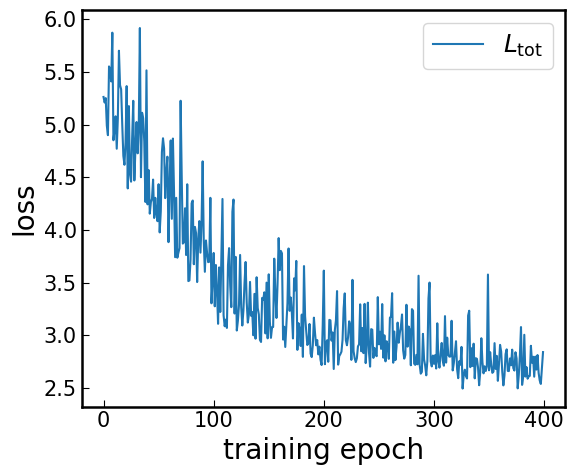

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.plot(trainer.lossList, label=r"$L_{\rm{tot}}$")
# ax.plot(losses, label=r'$L_{\rm{tot}}$')

ax.legend(loc="upper right")
ax.set_xlabel("training epoch", fontsize=20)
ax.set_ylabel("loss", fontsize=20)
fig.tight_layout()

### Inference

Inference should use the config with parameters that are used in training
cfg now already contains everything we've set previously. We changed it a little bit for inference:

In [18]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_temp.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.4  # set a custom testing threshold
predictor = toolkit.DefaultPredictor(cfg)

[08/30 12:59:12 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /home/shared/hsc/decam/models/model_temp.pth ...


total instances: 135
detected instances: 12

total instances: 131
detected instances: 6

total instances: 127
detected instances: 12



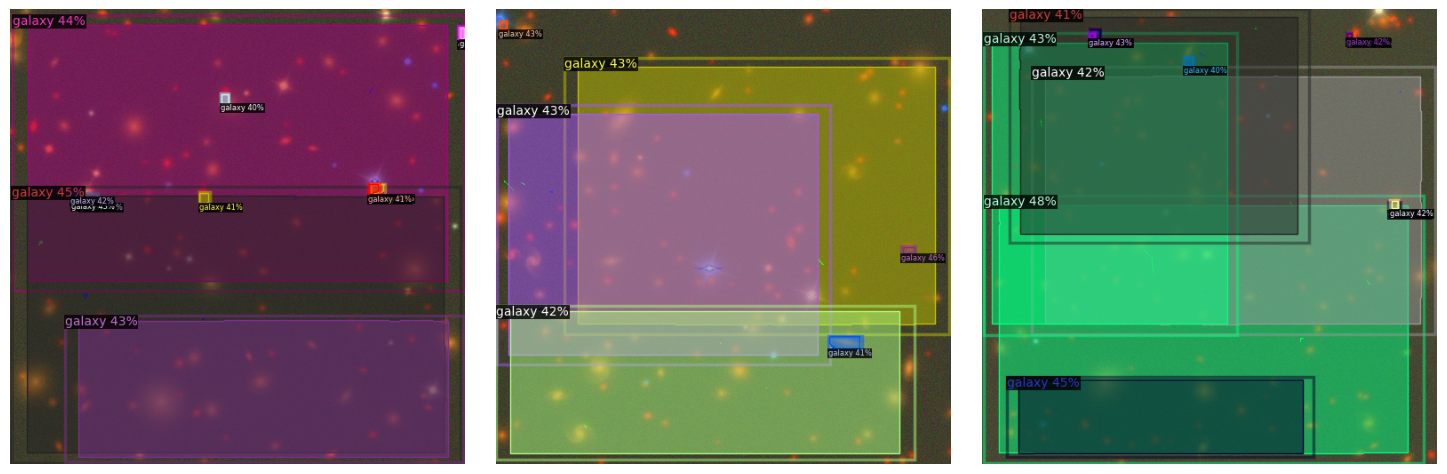

In [24]:
from detectron2.utils.visualizer import ColorMode

nsample = 3
fig, axs = plt.subplots(1, nsample, figsize=(5 * nsample, 5))

for i, d in enumerate(random.sample(dataset_dicts["test"], nsample)):
    img = toolkit.read_image_decam(d["file_name"], normalize="astrolupton", stretch=100, Q=10)
    outputs = predictor(
        img
    )  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format

    print("total instances:", len(d["annotations"]))
    print("detected instances:", len(outputs["instances"].pred_boxes))
    print("")

    v = Visualizer(
        img,
        metadata=astro_metadata,
        scale=1,
        instance_mode=ColorMode.SEGMENTATION,  # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    axs[i].imshow(out.get_image())
    axs[i].axis("off")
    fig.tight_layout()
    fig.show()

### Evaluate

In [50]:
def test_mapper(dataset_dict):

    dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below

    image = toolkit.read_image_decam(dataset_dict["file_name"], normalize="astrolupton", stretch=100, Q=10)
    augs = T.AugmentationList([])
    # Data Augmentation
    auginput = T.AugInput(image)
    # Transformations to model shapes
    transform = augs(auginput)
    image = torch.from_numpy(auginput.image.copy().transpose(2, 0, 1))
    annos = [
        utils.transform_instance_annotations(annotation, [transform], image.shape[1:])
        for annotation in dataset_dict.pop("annotations")
    ]
    return {
        # create the format that the model expects
        "image": image,
        "image_shaped": auginput.image,
        "height": 512,
        "width": 512,
        "image_id": dataset_dict["image_id"],
        "instances": utils.annotations_to_instances(annos, image.shape[1:]),
        "annotations": annos,
    }

In [51]:
from detectron2.evaluation import inference_on_dataset
from detectron2.data import build_detection_test_loader

# NOTE: New version has max_dets_per_image argument in default COCOEvaluator
evaluator = toolkit.COCOEvaluatorRecall("astro_val", use_fast_impl=True, output_dir=cfg.OUTPUT_DIR)

test_loader = build_detection_test_loader(dataset_dicts["val"], mapper=test_mapper)

Using previously cached COCO format annotations at '/home/shared/hsc/decam/models/astro_val_coco_format.json'. You need to clear the cache file if your dataset has been modified.


Loading  /home/shared/hsc/decam/models/astro_val_coco_format.json
[05/30 11:38:14 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[05/30 11:38:14 d2.data.common]: Serializing 20 elements to byte tensors and concatenating them all ...
[05/30 11:38:14 d2.data.common]: Serialized dataset takes 0.32 MiB


In [52]:
results = inference_on_dataset(predictor.model, test_loader, evaluator)

[05/30 11:38:17 d2.evaluation.evaluator]: Start inference on 20 batches
[05/30 11:38:21 d2.evaluation.evaluator]: Inference done 11/20. Dataloading: 0.0722 s/iter. Inference: 0.1998 s/iter. Eval: 0.0420 s/iter. Total: 0.3139 s/iter. ETA=0:00:02
[05/30 11:38:24 d2.evaluation.evaluator]: Total inference time: 0:00:04.846482 (0.323099 s / iter per device, on 1 devices)
[05/30 11:38:24 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:03 (0.202685 s / iter per device, on 1 devices)
()
_evaluate_predictions_on_coco
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
++++++++++ <class 'deepdisc.astrodet.astrodet.COCOeval_opt_custom'>
Running per image evaluation...
Evaluate annotation type *bbox*
[[0, 10000000000.0], [0, 1024], [1024, 9216], [9216, 10000000000.0]]
DONE (t=2.51s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50   

In [53]:
results["bbox"]["AP-star"]

0.0

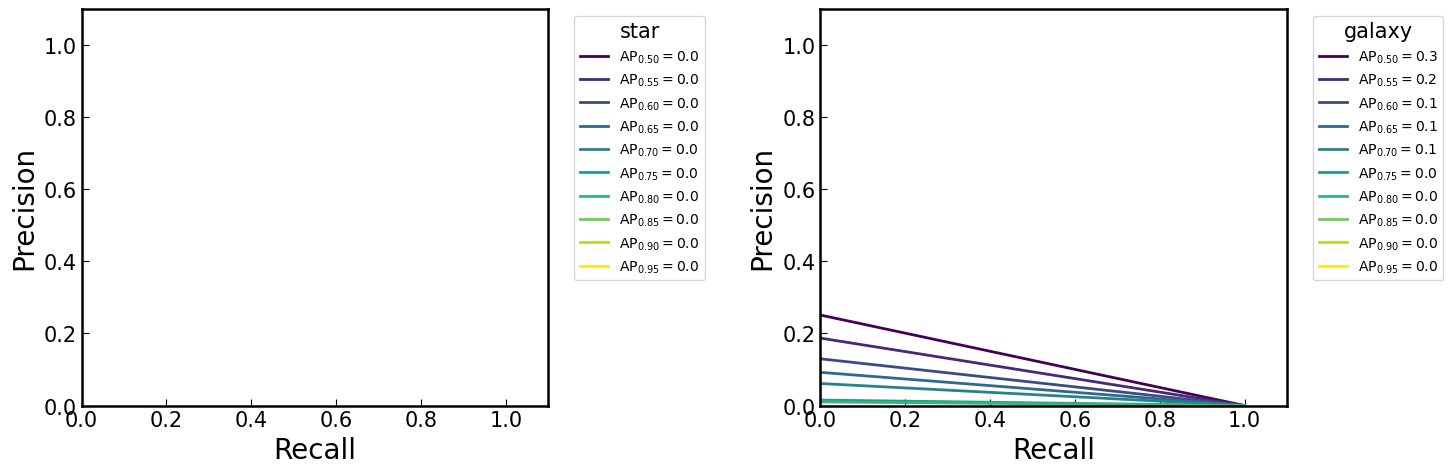

In [54]:
ap_type = "bbox"  # Which type of precision/recall to use? 'segm', or 'bbox'
cls_names = ["star", "galaxy"]

results_per_category = results[ap_type]["results_per_category"]

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs = axs.flatten()

ious = np.linspace(0.50, 0.95, 10)
colors = plt.cm.viridis(np.linspace(0, 1, len(ious)))

# Plot precision recall
for j, precision_class in enumerate(results_per_category):
    precision_shape = np.shape(precision_class)
    for i in range(precision_shape[0]):
        # precision has dims (iou, recall, cls, area range, max dets)
        # area range index 0: all area ranges
        # max dets index -1: typically 100 per image
        p_dat = precision_class[i, :, j, 0, -1]
        # Hide vanishing precisions
        mask = p_dat > 0
        # Only keep first occurance of 0 value in array
        mask[np.cumsum(~mask) == 1] = True
        p = p_dat[mask]
        # Recall points
        r = np.linspace(0, 1, len(p))  # Recall is always defined from 0 to 1 for these plots, I think
        dr = np.diff(np.linspace(0, 1, len(p_dat)))[0]  # i think
        # Plot
        iou = np.around(ious[i], 2)
        AP = 100 * np.sum(p * dr)
        axs[j].plot(
            r, p, label=r"${\rm{AP}}_{%.2f} = %.1f$" % (iou, AP), color=colors[i], lw=2
        )  # use a viridis color scheme
        axs[j].set_xlabel("Recall", fontsize=20)
        axs[j].set_ylabel("Precision", fontsize=20)
        axs[j].set_xlim(0, 1.1)
        axs[j].set_ylim(0, 1.1)
        axs[j].legend(fontsize=10, title=f"{cls_names[j]}", bbox_to_anchor=(1.35, 1.0))

fig.tight_layout()